Equation (6.8) in Sloan, Dynamical Symilarity,
$$
H = \Psi_1^2 + \Psi_2^2 + \frac{\Psi_\phi^2}{2} - \frac{\Phi^2}{6} +  V(q^1, q^2)
$$
corresponds to
$$
H = \sum\frac{|p_i|^2}2  + \gamma \frac{s^2}{2} +  V(q^1, q^2) 
$$
where $p_{1,2} = \sqrt{2}\Psi_{1,2}$, $p_\phi = p_\Psi$, $s = \Phi$, $\gamma = -1/3$ and $V$ remains the same.
In a flat universe, $V=0$. We will test here both $V=0$ and $V = \frac1{\|q\|}$.

In [1]:
from integrators import contact as ic
from integrators.common import rk4
import scipy.integrate as si

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [3]:
class CosmologicalKepler:
    def __init__(self, γ, α=1., v=True):
        self.γ = γ
        self.α = α
        self.v = v

    def f(self, t):
        return self.γ

    def V(self, q, t):
        if self.v:
            return self.α/np.linalg.norm(q, ord=2)
        else:
            return 0.0
    
    def Vq(self, q, t):
        if self.v:
            return - q * self.α/np.linalg.norm(q, ord=2)**3
        else:
            return 0.0
    
    def lag(self, q,v,z,t):
        return .5 * np.linalg.norm(v)**2 - self.V(q,t) - self.f(t) * z**2 / 2
    
    def lagq(self, q,v,z,t):
        return -self.Vq(q,t)
    
    def lagv(self, q,v,z,t):
        return v
    
    def lagz(self, q,v,z,t):
        return - self.f(t) * z
    
    def energy(self, p, q, z, t):
        return 0.5*np.linalg.norm(p, ord=2)**2 + self.f(t) * z**2 / 2 + self.V(q, t)

In [14]:
def rk4s(system, init, tspan):
    n = len(init)
    def derivs(x, t):
        p = x[:(n-1)//2]
        q = x[(n-1)//2:n-1]
        s = x[-1]
        dp = - system.Vq(q,t) - system.f(t) * p * s
        dq = p
        ds = system.lag(p, q, s, t)
        return np.concatenate([dp, dq, [ds]])
    return rk4(derivs, init, tspan)

def adaptive(system, init, tspan):
    t_span = (tspan[0], tspan[-1]) 
    n = len(init)
    def derivs(t, x):
        p = x[:(n-1)//2]
        q = x[(n-1)//2:n-1]
        s = x[-1]
        dp = - system.Vq(q,t) - system.f(t) * p * s
        dq = p
        ds = system.lag(p, q, s, t)
        return np.concatenate([dp, dq, [ds]])
    return si.solve_ivp(derivs, t_span, init, t_eval=tspan, dense_output=True)

In [15]:
e = 0.2
init_ecc = lambda e, s: [np.array([1.0 - e, 0.0]), np.array([0.0, np.sqrt((1+e)/(1-e))]), np.array([0.0])]
init = init_ecc(e, 0.0)

energy = lambda ck, pq, z, tspan: np.array([ck.energy(pq[:,0][i], pq[:,1][i], z[i], t) for i,t in enumerate(tspan)])
print(init)

[array([0.8, 0. ]), array([0.        , 1.22474487]), array([0.])]


## RK4 comparisons

<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: overflow encountered in double_scalars
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-14-20577451c0cf>:7: RuntimeWarning: overflow encountered in multiply
  dp = - system.Vq(q,t) - system.f(t) * p * s
<ipython-input-3-44c241fe0d25>:23: RuntimeWarning: overflow encountered in double_scalars
  return .5 * np.linalg.norm(v)**2 - self.V(q,t) - self.f(t) * z**2 / 2
<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: invalid value encountered in true_divide
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-16-3fc436a501ea>:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-14-20577451c0cf>:7: RuntimeWarning: overflow encountered in multiply
  dp = - system.Vq(q,t) - system.f(t) * p * s
<ipython-input-3-44c241fe0d25>:23: RuntimeWarning: overflow encountered in double_scalars
  return .5 * np.l

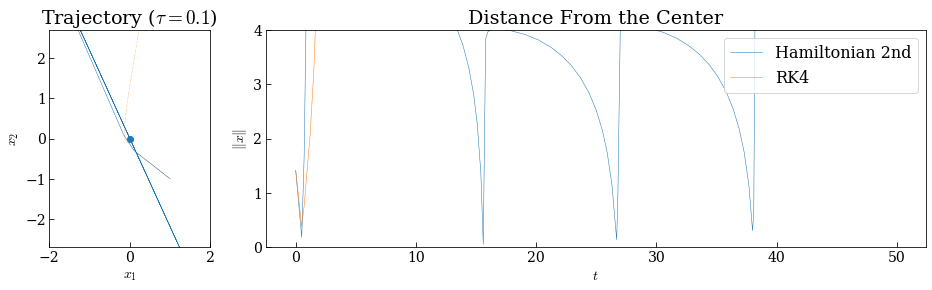

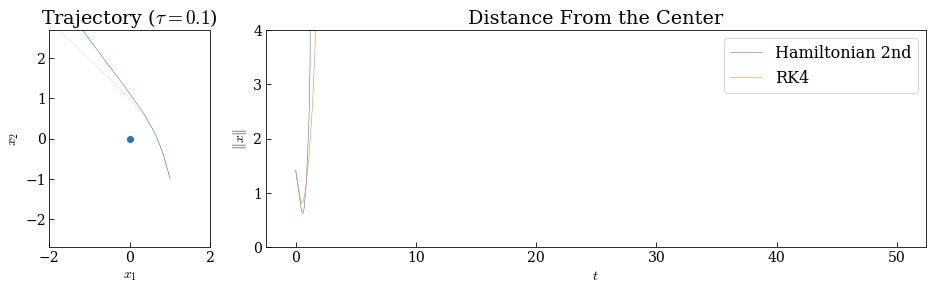

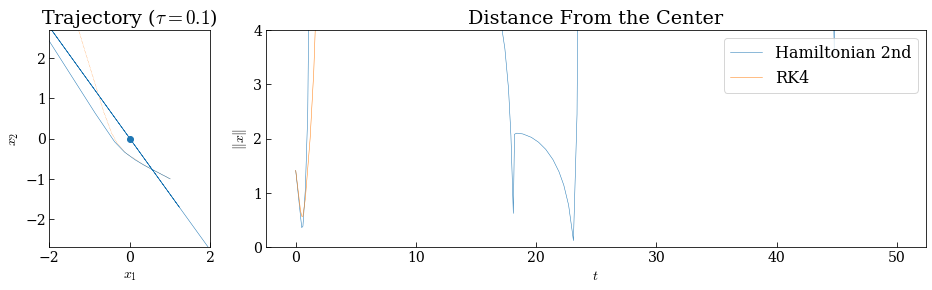

In [16]:
tpk = CosmologicalKepler(-1/3, α=-1)
dt = 0.1
tf = 50

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0, s0) in [
    (np.array([-2,1.5]), np.array([1,-1]), np.array([0])),
    (np.array([-0.5,2]), np.array([1,-1]), np.array([0])),
    (np.array([-2,1.]), np.array([1,-1]), np.array([0])),
    ]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0, q0, s0]), tspan)
    
    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
                
    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.5,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.5, label="Hamiltonian 2nd")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
    
    axe.plot(tspan,
             dc,
             linewidth=0.5, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.5, label="RK4")    

    axe.set_ylim(0, 4)
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
#     fig.savefig(f"images/TPK01.pdf", bbox_inches='tight')
    fig.show()

<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: overflow encountered in double_scalars
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-14-20577451c0cf>:7: RuntimeWarning: overflow encountered in multiply
  dp = - system.Vq(q,t) - system.f(t) * p * s
<ipython-input-3-44c241fe0d25>:23: RuntimeWarning: overflow encountered in double_scalars
  return .5 * np.linalg.norm(v)**2 - self.V(q,t) - self.f(t) * z**2 / 2
<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: invalid value encountered in true_divide
  return - q * self.α/np.linalg.norm(q, ord=2)**3


ValueError: x and y must have same first dimension, but have shapes (500,) and (25,)

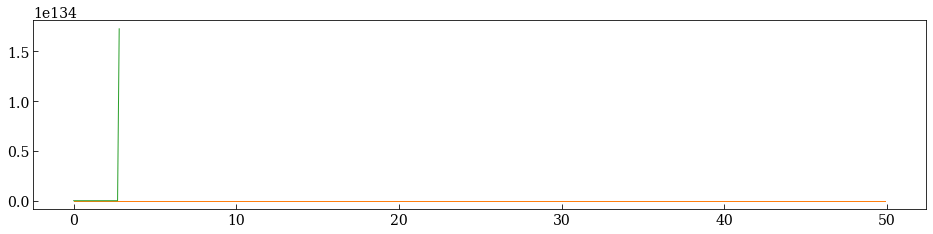

In [17]:
for (p0, q0, s0) in [
    (np.array([-2,1.5]), np.array([1,-1]), np.array([0])),
    (np.array([-0.5,2]), np.array([1,-1]), np.array([0])),
    (np.array([-2,1.]), np.array([1,-1]), np.array([0])),
    ]:
    fig = plt.figure(figsize=(16,16))
    
    sol, sols, _ = ic.integrate(ic.step1l, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)
    r = adaptive(tpk, np.concatenate([p0,q0,s0]), tspan)
    plt.subplot(411)
    plt.plot(tspan, sol[:,1], label="Contact", linewidth=1)
    plt.plot(tspan, solrk.T[1], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[1], label="Reference", linewidth=1)
    plt.legend()
    plt.subplot(412)
    plt.plot(tspan, sol[:,0], label="Contact", linewidth=1)
    plt.plot(tspan, solrk.T[0], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[0], label="Reference", linewidth=1)
    plt.subplot(413)
    plt.plot(tspan, mosc.energy(sol[:,0], sol[:,1], sols, tspan), label="Contact", linewidth=1)
    plt.plot(tspan, mosc.energy(solrk.T[0], solrk.T[1], solrk.T[2], tspan), label="RK4", linewidth=1)
    plt.plot(tspan, mosc.energy(r.y[0], r.y[1], r.y[2], tspan), label="Reference", linewidth=1)
    plt.subplot(414)
    cut=100
    plt.plot(tspan[:cut], mosc.energy(sol[:,0][:cut], sol[:,1][:cut], sols[:cut], tspan[:cut]), label="Contact", linewidth=1)
    plt.plot(tspan[:cut], mosc.energy(solrk.T[0][:cut], solrk.T[1][:cut], solrk.T[2][:cut], tspan[:cut]), label="RK4", linewidth=1)
    plt.plot(tspan[:cut], mosc.energy(r.y[0][:cut], r.y[1][:cut], r.y[2][:cut], tspan[:cut]), label="Reference", linewidth=1)
    plt.legend()

    plt.show()


<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: overflow encountered in double_scalars
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-14-20577451c0cf>:7: RuntimeWarning: overflow encountered in multiply
  dp = - system.Vq(q,t) - system.f(t) * p * s
<ipython-input-3-44c241fe0d25>:23: RuntimeWarning: overflow encountered in double_scalars
  return .5 * np.linalg.norm(v)**2 - self.V(q,t) - self.f(t) * z**2 / 2
<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: invalid value encountered in true_divide
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-18-bec3acd62383>:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


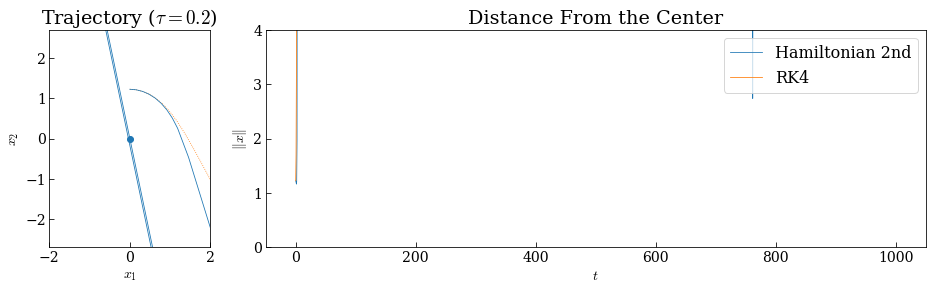

In [18]:
dt = 0.2
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0, s0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
                
    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
        
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)
    
    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
        
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
        
    axe.plot(tspan,
             dc,
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.8, label="RK4")    

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')
    
    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    fig.savefig(f"images/TPK02.pdf", bbox_inches='tight')

    fig.show()

<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: overflow encountered in double_scalars
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-14-20577451c0cf>:7: RuntimeWarning: overflow encountered in multiply
  dp = - system.Vq(q,t) - system.f(t) * p * s
<ipython-input-3-44c241fe0d25>:23: RuntimeWarning: overflow encountered in double_scalars
  return .5 * np.linalg.norm(v)**2 - self.V(q,t) - self.f(t) * z**2 / 2
<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: invalid value encountered in true_divide
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-19-ecbcb2d3dd7c>:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


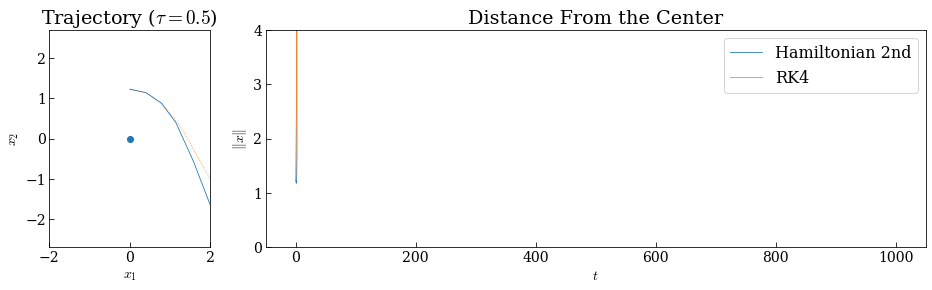

In [19]:
dt = 0.5
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist

    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
    
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")
    
    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")

    axe.plot(tspan,
             dc,
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.8, label="RK4")    

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')
    
    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")    
    
    fig.savefig(f"images/TPK05.pdf", bbox_inches='tight')

    fig.show()

<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: overflow encountered in double_scalars
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-14-20577451c0cf>:7: RuntimeWarning: overflow encountered in multiply
  dp = - system.Vq(q,t) - system.f(t) * p * s
<ipython-input-3-44c241fe0d25>:23: RuntimeWarning: overflow encountered in double_scalars
  return .5 * np.linalg.norm(v)**2 - self.V(q,t) - self.f(t) * z**2 / 2
<ipython-input-3-44c241fe0d25>:18: RuntimeWarning: invalid value encountered in true_divide
  return - q * self.α/np.linalg.norm(q, ord=2)**3
<ipython-input-20-0cd4eccdadbf>:84: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


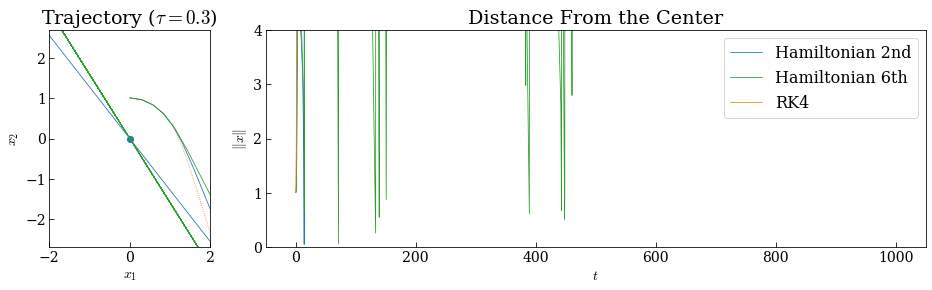

In [20]:
dt = 0.3
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=len(tspan)
dc = np.empty(steps, dtype=np.float64)
dc6 = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0, s0) in [init_ecc(0.01, 1.0)]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, s0)
    sol6, sols6, _ = ic.integrate(ic.step6q, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
        dist6=np.sqrt(sol6[i,1,0]*sol6[i,1,0] + sol6[i,1,1]*sol6[i,1,1])
        dc6[i]=dist6
        distrk=np.linalg.norm(solrk[i][2:])
        drk[i]=distrk
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
    
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axo.plot(sol6[:,1,0],
             sol6[:,1,1],
             c='C2',
             linewidth=0.8, label="Hamiltonian 6th")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)
    
    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")
    
    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")

    axe.plot(tspan,
             dc,
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             dc6,
             c='C2',
             linewidth=0.8, label="Hamiltonian 6th")
    
    axe.plot(tspan,
             drk,
             c='C1',
             linewidth=0.8, label="RK4")

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    fig.savefig(f"images/TPK03prec.pdf", bbox_inches='tight')

    fig.show()